The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 多GPU训练
:label:`sec_multi_gpu`

到目前为止，我们讨论了如何在CPU和GPU上高效地训练模型。我们甚至在 :numref:`sec_auto_para` 中展示了深度学习框架如何使它们之间的计算和通信自动并行化。我们还在 :numref:`sec_use_gpu` 中展示了如何使用 `nvidia-smi` 命令列出计算机上所有可用的GPU。我们没有讨论的是如何真正实现深度学习训练的并行化。我们暗示了一种方法，即以某种方式将数据分割到多个设备上，并使其正常工作。本节将详细介绍如何从零开始并行训练网络。关于如何利用高级API中的详情请参阅 :numref:`sec_multi_gpu_concise` 。我们假设你熟悉小批量随机梯度下降算法，如  :numref:`sec_minibatch_sgd` 中描述的算法。

## 拆分问题

让我们从一个简单的计算机视觉问题和一个稍微旧点的网络开始，例如，有多个卷积层和池化层，最后可能有几个全连接的层。也就是说，让我们从一个看起来非常类似于 LeNet :cite:`LeCun.Bottou.Bengio.ea.1998`或AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012`的网络开始。假设有多个GPU（如果是桌面服务器则为2个，AWS g4dn.12xlarge实例上为4个，p3.16xlarge上为8个，p2.16xlarge上为16个），我们希望以一种方式对训练进行拆分，以实现良好的加速比，同时受益于简单且可重复的设计选择。毕竟，多个GPU同时增加了内存和计算能力。简而言之，给出一小批量我们想要分类的训练数据，我们有以下选择。

首先，我们可以在多个GPU之间拆分网络。也就是说，每个GPU将流入特定层的数据作为输入，跨多个后续层处理数据，然后将数据发送到下一个GPU。与单个GPU所能处理的数据相比，这使我们可以用更大的网络处理数据。此外，每个GPU的显存占用可以得到很好的控制（它只是整个网络占用的一小部分）。

然而，层（以及GPU）之间的接口需要紧密同步。这可能很棘手，特别是在计算工作负载在层之间没有正确匹配的时候。对于大量的GPU来说，这个问题更加严重。层之间的接口还需要大量的数据传输，例如激活值和梯度。这可能会超出GPU总线的带宽。此外，计算密集型的操作顺序对于拆分来说是非常重要的。有关这方面的最佳努力，请参见 :cite:`Mirhoseini.Pham.Le.ea.2017` 。这仍然是一个困难的问题，目前还不清楚是否有可能在特定问题上实现良好的（线性）缩放。除非有优秀的框架或操作系统支持将多个GPU连接在一起，否则我们不建议使用它。

第二，我们可以拆分工作。例如，我们可以将问题分散到4个GPU，每个GPU生成16个通道的数据，而不是在单个GPU上计算64个通道。同样，对于全连接的层，我们可以拆分输出单元的数量。 :numref:`fig_alexnet_original` （来自 :cite:`Krizhevsky.Sutskever.Hinton.2012` ）说明了这种设计，这种策略用于显存非常小（当时为2GB）的GPU。这允许在计算方面进行良好的缩放，前提是通道（或单元）的数量不太小。此外，由于可用显存呈线性扩展，多个GPU可以处理越来越大的网络。

![由于GPU显存有限，原有AlexNet设计中存在模型并行性问题。](../img/alexnet-original.svg)
:label:`fig_alexnet_original`

但是，我们需要非常多的同步或阻塞操作，因为每一层都依赖于所有其他层的结果。此外，此外，需要传输的数据量可能比跨GPU拆分层时还要大。因此，由于其带宽成本和复杂性，我们不推荐这种方法。

最后，我们可以跨多个GPU对数据进行拆分。通过这种方式，所有GPU执行相同类型的工作，尽管观察结果不同。在每个小批量的训练数据之后，梯度在GPU上聚合。这是最简单的方法，可以应用于任何情况。我们只需要在每个小批处理之后进行同步。也就是说，当其他梯度参数仍在计算时，开始交换梯度参数是非常可取的。此外，GPU数量越多，小批量越大，从而提高了训练效率。但是，添加更多GPU并不能让我们训练更大的模型。

![在多个GPU上并行化。从左到右：原始问题、网络并行、分层并行、数据并行。](http://d2l.ai/_images/splitting.svg)
:label:`fig_splitting`

:numref:`fig_splitting`中描述了多个GPU上不同并行方式的比较。总的来说，数据并行是最方便的方法，只要我们能访问有足够大显存的GPU。有关分布式训练并行的详细描述，请参见 :cite:`Li.Andersen.Park.ea.2014` 。GPU显存在深度学习的早期曾经是一个问题。到目前为止，除了最不寻常的情况外，这个问题已经解决了。下面我们将重点讨论数据并行性。

## 数据并行性

假设机器上有$k$个GPU。给定要训练的模型，每个GPU将独立地维护一组完整的模型参数，尽管GPU上的参数值是相同且同步的。例如， :numref:`fig_data_parallel` 演示了在$k=2$时使用数据并行的训练。

![利用两个GPU上的数据并行计算小批量随机梯度下降。](../img/data-parallel.svg)
:label:`fig_data_parallel`

一般来说，训练过程如下：

* 在训练的任何迭代中，给定一个随机的小批量，我们将该小批量中的样本分成$k$个部分，并将它们均匀地分在多个GPU上。
* 每个GPU根据分配给它的小批量子集计算模型参数的损失和梯度。
* 将$k$个GPU中每个GPU的局部梯度聚合以获得当前的小批量随机梯度。
* 聚合梯度被重新分配到每个GPU。
* 每个GPU使用这个小批量随机梯度来更新它维护的完整的模型参数集。

请注意，在实践中，当在$k$个GPU上训练时，我们将小批量大小增加$k$倍，这样每个GPU都有相同的工作量，就像我们只在单个GPU上训练一样。在16-GPU服务器上，这可以大大增加小批量大小，我们可能需要相应地提高学习速率。还请注意， :numref:`sec_batch_norm` 中的批量归一化需要调整，例如，为每个GPU保留单独的批量归一化参数。下面我们将使用一个简单网络来演示多GPU训练。


In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


## 简单网络

我们使用 :numref:`sec_lenet` 中介绍的LeNet（稍加修改）。我们从零开始定义它，从而详细说明参数交换和同步。


In [2]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

## 数据同步

对于高效的多GPU训练，我们需要两个基本操作。首先，我们需要有能力将参数列表分发给多个设备并附加梯度（`get_params`）。如果没有参数，就不可能在GPU上评估网络。第二，我们需要跨多个设备对参数求和的能力，也就是说，我们需要一个`allreduce`函数。


In [3]:
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

让我们通过将模型参数复制到一个GPU来尝试一下。


In [4]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


由于我们还没有进行任何计算，偏置参数的梯度仍然为零。现在假设有一个向量分布在多个GPU上。下面的`allreduce`函数将所有向量相加，并将结果广播回所有GPU。请注意，要使其工作，我们需要将数据复制到累积结果的设备。


In [5]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)

让我们通过在不同设备上创建具有不同值的向量并聚合它们来测试这一点。


In [6]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


## 分发数据

我们需要一个简单的实用函数来将一个小批量均匀地分布在多个GPU上。例如，在有两个GPU的时候，我们希望将一半的数据复制到其中一个GPU。因为深度学习框架中的内置函数更方便、更简洁，所以我们使用它在$4 \times 5$矩阵上进行了尝试。


In [7]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


为了以后的复用，我们定义了一个`split_batch`函数，该函数同时拆分数据和标签。


In [8]:
#@save
def split_batch(X, y, devices):
    """将`X`和`y`拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices), nn.parallel.scatter(y, devices))

## 训练

现在我们可以在一个小批量上实现多GPU训练。它的实现主要基于本节描述的数据并行方法。我们将使用刚才讨论的辅助函数`allreduce`和`split_and_load`在多个GPU之间同步数据。注意，我们不需要编写任何特定的代码来实现并行性。由于计算图在小批量内的设备之间没有任何依赖关系，因此它是自动并行执行的。


In [9]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [
        loss(lenet(X_shard, device_W),
             y_shard).sum() for X_shard, y_shard, device_W in zip(
                 X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0])  # 在这里，我们使用全尺寸的小批量

现在，我们可以定义训练函数。它与前几章中使用的略有不同：我们需要分配GPU并将所有模型参数复制到所有设备。显然，每个小批量都是使用`train_batch`函数来处理多个GPU的。为了方便（和代码的简洁性），我们在一个GPU上计算精度，尽管这是低效的，因为其他GPU是空闲的。


In [10]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到`num_gpus`个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU 0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

让我们看看这在单个GPU上运行得有多好。我们首先使用批量大小256，学习率为0.2。


test acc: 0.82, 2.4 sec/epoch on [device(type='cuda', index=0)]


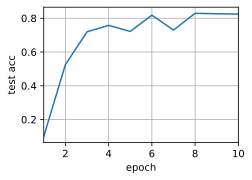

In [11]:
train(num_gpus=1, batch_size=256, lr=0.2)

通过保持批量大小和学习率不变，并将GPU数增加到2，我们可以看到测试精度与之前的实验基本相同。在优化算法方面，它们是相同的。不幸的是，这里没有任何有意义的加速：模型实在太小了；而且，我们只有一个很小的数据集，在这个数据集中，我们实现多GPU训练的简单方法受到了巨大的Python开销的影响。在未来，我们将遇到更复杂的模型和更复杂的并行化方法。尽管如此，让我们看看Fashion-MNIST会发生什么。


test acc: 0.82, 2.4 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


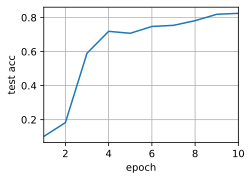

In [12]:
train(num_gpus=2, batch_size=256, lr=0.2)

## 小结

* 有多种方法可以在多个GPU上拆分深度网络训练。我们可以在层之间、跨层或跨数据拆分它们。前两者需要经过严格编排的数据传输。数据并行是最简单的策略。
* 数据并行训练非常简单。但是，它增加了有效的小批量大小以提高效率。
* 在数据并行中，数据跨多个GPU拆分，其中每个GPU执行其自己的前向传播和反向传播，随后聚合梯度并将结果广播回GPU。
* 对于较大的小批量，我们可以使用稍微提高的学习率。

## 练习

1. 在$k$个GPU上进行训练时，将批量大小从$b$更改为$k \cdot b$，即按GPU的数量进行扩展。
1. 比较不同学习率的准确性。它如何随着GPU数量的增加而扩展？
1. 实现一个更高效的`allreduce`函数，在不同的GPU上聚合不同的参数？为什么效率更高？
1. 实现多GPU测试精度计算。


[Discussions](https://discuss.d2l.ai/t/2800)
